In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from torch import Tensor
from tqdm import tqdm
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import json
import os
import random
import time
import re
from jaxtyping import Float
import gc

In [2]:
def generate_data():
    start_time = time.time()
    
    # 设置随机种子以确保可复现性
    random.seed(42)
    
    # 读取姓名和句子数据
    with open('names.json', 'r') as f:
        names = json.load(f)
    
    with open('sentences.json', 'r') as f:
        sentences = json.load(f)
    
    # 随机选择50个组合
    results = []
    for _ in range(50):
        # 随机选择一个姓名对和一个句子对
        name_pair = random.choice(names)
        sentence_pair = random.choice(sentences)
        
        # 替换句子中的A和B
        clean_sentence = sentence_pair["clean"].replace("A ", name_pair["A"] + " ").replace("B ", name_pair["B"] + " ")
        corrupted_sentence = sentence_pair["corrupted"].replace("A ", name_pair["A"] + " ").replace("B ", name_pair["B"] + " ")
        
        # 确定答案
        clean_answer = " " + name_pair["B"]  # 在clean句子中，给东西的是A，所以答案是B
        corrupted_answer = " " + name_pair["A"]  # 在corrupted句子中，给东西的是B，所以答案是A
        
        # 添加到结果列表
        results.append({
            "clean": clean_sentence,
            "corrupted": corrupted_sentence,
            "clean_answer": clean_answer,
            "corrupted_answer": corrupted_answer
        })
    
    # 保存结果到data.json
    with open('data.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    # 计算并输出执行时间
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"函数执行时间: {execution_time:.4f} 秒")
    
    return results

In [3]:
generated_data = generate_data()

函数执行时间: 0.0025 秒


In [4]:
def check_sentence_structure():
    start_time = time.time()
    
    # 读取数据文件
    with open('data.json', 'r') as f:
        data = json.load(f)
    
    print(f"筛选前数据条数: {len(data)}")
    
    # 用于存储符合要求的数据
    checked_data = []
    
    # 定义正则表达式模式来匹配句子结构
    # clean句子模式: "After [A] and [B] [do sth], A [do another sth] to"
    # corrupted句子模式: "After [A] and [B] [do sth], B [do another sth] to"
    clean_pattern = r"After (.+?) and (.+?) (.+?), \1 (.+?) to"
    corrupted_pattern = r"After (.+?) and (.+?) (.+?), \2 (.+?) to"
    
    for item in data:
        clean_sentence = item["clean"]
        corrupted_sentence = item["corrupted"]
        clean_answer = item["clean_answer"]
        corrupted_answer = item["corrupted_answer"]
        
        # 检查clean句子结构
        clean_match = re.match(clean_pattern, clean_sentence)
        if not clean_match:
            continue
            
        # 检查corrupted句子结构
        corrupted_match = re.match(corrupted_pattern, corrupted_sentence)
        if not corrupted_match:
            continue
            
        # 提取匹配的组
        clean_A, clean_B, clean_action1, clean_action2 = clean_match.groups()
        corrupted_A, corrupted_B, corrupted_action1, corrupted_action2 = corrupted_match.groups()
        
        # 检查A和B在两个句子中是否一致
        if clean_A != corrupted_A or clean_B != corrupted_B:
            continue
            
        # 检查动作在两个句子中是否一致
        if clean_action1 != corrupted_action1 or clean_action2 != corrupted_action2:
            continue
            
        # 检查A和B是否与答案匹配
        if " " + clean_A != corrupted_answer or " " + clean_B != clean_answer:
            continue
            
        # 如果所有检查都通过，则添加到结果中
        checked_data.append(item)
    
    # 保存检查后的数据
    with open('data_check1.json', 'w') as f:
        json.dump(checked_data, f, indent=2)
    
    # 计算并输出执行时间
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"筛选后数据条数: {len(checked_data)}")
    print(f"函数执行时间: {execution_time:.4f} 秒")
    
    return checked_data

In [5]:
result = check_sentence_structure()

筛选前数据条数: 50
筛选后数据条数: 50
函数执行时间: 0.0024 秒


In [7]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000025F24B41D10>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 175dff95-4112-46a9-84f8-7945896c31d7)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000025F24B41BD0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 242d8e6a-af6b-496e-a829-28b21a52f5fe)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): M

Loaded pretrained model gpt2-small into HookedTransformer


In [7]:
def filter_with_gpt2():
    start_time = time.time()
    
    # 读取数据文件
    with open('data_check1.json', 'r') as f:
        data = json.load(f)
    
    print(f"筛选前数据条数: {len(data)}")
    
    # 设置填充token（GPT-2没有明确的填充token，使用eos_token）
    
    # 用于存储符合要求的数据
    filtered_data = []
    
    # 对每个数据项进行处理
    for i, item in enumerate(data):
        clean_sentence = item["clean"]
        corrupted_sentence = item["corrupted"]
        clean_answer = item["clean_answer"]
        corrupted_answer = item["corrupted_answer"]
        
        # 检查clean句子
        
        with torch.no_grad():
            clean_outputs = model.generate(
                clean_sentence,
                max_new_tokens=1,  # 只生成一个token
                temperature=0,     # 温度设为0，确保确定性输出
                do_sample=False,   # 不使用采样，使用贪婪解码
                return_type="tokens"  
            )
            
            # 获取生成的token
            clean_generated_token_id = clean_outputs[0, -1]
            clean_generated_text = model.to_string(clean_generated_token_id)
            
            corrupted_outputs = model.generate(
                corrupted_sentence,
                max_new_tokens=1,  # 只生成一个token
                temperature=0,     # 温度设为0，确保确定性输出
                do_sample=False,   # 不使用采样，使用贪婪解码
                return_type="tokens"  
            )
            
            # 获取生成的token
            corrupted_generated_token_id = corrupted_outputs[0, -1]
            corrupted_generated_text = model.to_string(corrupted_generated_token_id)
        
        # 检查生成的文本是否是答案或答案的前缀
        clean_correct = (clean_generated_text in clean_answer or clean_answer in clean_generated_text)
        corrupted_correct = (corrupted_generated_text in corrupted_answer or corrupted_answer in corrupted_generated_text)
        
        # 如果两个句子都正确，则保留该数据项
        if clean_correct and corrupted_correct:
            # 添加生成的文本到数据项中，便于调试
            item["clean_generated"] = clean_generated_text
            item["corrupted_generated"] = corrupted_generated_text
            filtered_data.append(item)
        else:
            print(clean_generated_text, clean_answer, corrupted_generated_text, corrupted_answer)
        
        # 打印进度（每10条打印一次）
        if (i + 1) % 10 == 0:
            print(f"已处理 {i + 1}/{len(data)} 条数据")
    
    # 保存筛选后的数据
    with open('data_check2.json', 'w') as f:
        json.dump(filtered_data, f, indent=2)
    
    # 计算并输出执行时间
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"筛选后数据条数: {len(filtered_data)}")
    print(f"函数执行时间: {execution_time:.4f} 秒")
    

device = torch.device("cuda")
filter_with_gpt2()    

筛选前数据条数: 50


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 Harper  Harper  the  Christopher


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

已处理 10/50 条数据


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

已处理 20/50 条数据


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

已处理 30/50 条数据


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 Harper  Harper  Harper  Christopher


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

已处理 40/50 条数据


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 Harper  Harper  Harper  Christopher


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

已处理 50/50 条数据
筛选后数据条数: 47
函数执行时间: 22.5000 秒


In [8]:
def get_logits_diff(logits, token1, token2):
    return logits[token1] - logits[token2]

In [9]:
def get_clean_activations():
    start_time = time.time()

    with open('data_check2.json', 'r') as f:
        data = json.load(f)
    
    print(f"数据条数: {len(data)}")
    case_number = len(data)
    clean_z = []
    clean_logits_diffs = []
    corrupted_logits_diffs = []
    clean_sentences = []
    corrupted_sentences = []
    clean_answers = []
    corrupted_answers = []

    for i in tqdm(range(case_number)):
        clean_sentence_tokens = model.to_tokens(data[i]["clean"])
        corrupted_sentence_tokens = model.to_tokens(data[i]["corrupted"])
        if clean_sentence_tokens.shape != corrupted_sentence_tokens.shape:
            continue
        clean_answer_token = model.to_tokens(data[i]["clean_generated"])[0][1]
        corrupted_answer_token = model.to_tokens(data[i]["corrupted_generated"])[0][1]
        corrupted_logits, corrupted_cache = model.run_with_cache(
            corrupted_sentence_tokens, 
            names_filter = lambda name: name.endswith("hook_z"),
            remove_batch_dim=True            
        )
        clean_logits, clean_cache = model.run_with_cache(
            clean_sentence_tokens, 
            names_filter = lambda name: name.endswith("hook_z"),
            remove_batch_dim=True
        )
        clean_logits_diff = get_logits_diff(clean_logits[0][-1], clean_answer_token, corrupted_answer_token)
        corrupted_logits_diff = get_logits_diff(corrupted_logits[0][-1], clean_answer_token, corrupted_answer_token)
        clean_logits_diffs.append(clean_logits_diff)
        corrupted_logits_diffs.append(corrupted_logits_diff)
        z_stacked = clean_cache.stack_activation("z") # [nlayers, seq, nheads, dhead]
        clean_sentences.append(clean_sentence_tokens)
        corrupted_sentences.append(corrupted_sentence_tokens)
        clean_answers.append(clean_answer_token)
        corrupted_answers.append(corrupted_answer_token)

        clean_z.append(z_stacked)
        del clean_cache, corrupted_cache, clean_logits, corrupted_logits
        torch.cuda.empty_cache()


    save_data = {
        "clean_z": clean_z,
        "clean_sentences": clean_sentences,
        "corrupted_sentences": corrupted_sentences,
        "clean_answers": clean_answers,
        "corrupted_answers": corrupted_answers,
        "clean_logits_diff": clean_logits_diffs,
        "corrupted_logits_diff": corrupted_logits_diffs
    }
    torch.save(save_data, "saved_data.pt")
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"保留数据条数{len(clean_logits_diffs)}")
    
    print(f"函数执行时间: {execution_time:.4f} 秒")

get_clean_activations()
torch.cuda.empty_cache()
gc.collect()



数据条数: 47


100%|██████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.93it/s]


保留数据条数31
函数执行时间: 8.0157 秒


513

In [10]:
device = "cuda"
def patch_head_vector(
    corrupted_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    head_index: int,
    clean_head_vector: Float[Tensor, "batch pos head_index d_head"],
) -> Float[Tensor, "batch pos head_index d_head"]:

    corrupted_head_vector[:, :, head_index] = clean_head_vector[:, head_index]
    return corrupted_head_vector

def ioi_metric(clean, corrupted, patched):
    # print(patched, corrupted, clean)
    # print((patched - corrupted) / (clean - corrupted))
    return (patched - corrupted) / (clean - corrupted)


def activation_patching():
    start_time = time.time()

    save_data = torch.load("saved_data.pt")
    
    clean_z = save_data["clean_z"]
    clean_logits_diffs = save_data["clean_logits_diff"] 
    corrupted_logits_diffs = save_data["corrupted_logits_diff"]
    # print(clean_logits_diffs)
    # print(corrupted_logits_diffs)
    clean_sentences = save_data["clean_sentences"]
    corrupted_sentences = save_data["corrupted_sentences"]
    clean_answers = save_data["clean_answers"]
    corrupted_answers = save_data["corrupted_answers"]
    case_number = len(clean_answers)
    


    rdm_cases = []
    if case_number < 10:
        rdm_cases = list(range(case_number))
    else:
        rdm_cases = random.sample(range(case_number), 10)
    print(f"random_case_number: {len(rdm_cases)}")
    results = torch.zeros(len(rdm_cases), model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32)
    
    for cnt, i in tqdm(enumerate(rdm_cases)):
        model.reset_hooks()

        clean_sentence_tokens = clean_sentences[i]
        corrupted_sentence_tokens = corrupted_sentences[i]
        clean_answer_token = clean_answers[i]
        corrupted_answer_token = corrupted_answers[i]
        torch.set_grad_enabled(False)  
        for layer in range(model.cfg.n_layers):
            for head in range(model.cfg.n_heads):
                
                hook_fn = partial(patch_head_vector, head_index=head, clean_head_vector = clean_z[i][layer])
                patched_logits = model.run_with_hooks(
                    corrupted_sentence_tokens,
                    fwd_hooks=[(utils.get_act_name("z", layer), hook_fn)],
                    return_type="logits",                    
                )
                patched_logits_diff = get_logits_diff(patched_logits[0][-1], clean_answer_token, corrupted_answer_token)
                clean_logits_diff = clean_logits_diffs[i]
                corrupted_logits_diff = corrupted_logits_diffs[i]
                results[cnt, layer, head] = ioi_metric(clean_logits_diff, corrupted_logits_diff, patched_logits_diff)
                model.reset_hooks()
                del patched_logits
        torch.cuda.empty_cache()
        gc.collect()
    # print(results)
    results = results.mean(dim=0)
    torch.save(results, "results.pt")

    torch.cuda.empty_cache()
    gc.collect()
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"函数执行时间: {execution_time:.4f} 秒")

activation_patching()

random_case_number: 10


AssertionError: Torch not compiled with CUDA enabled

热力图已保存至: HeatMap.png
函数执行时间: 0.8153 秒


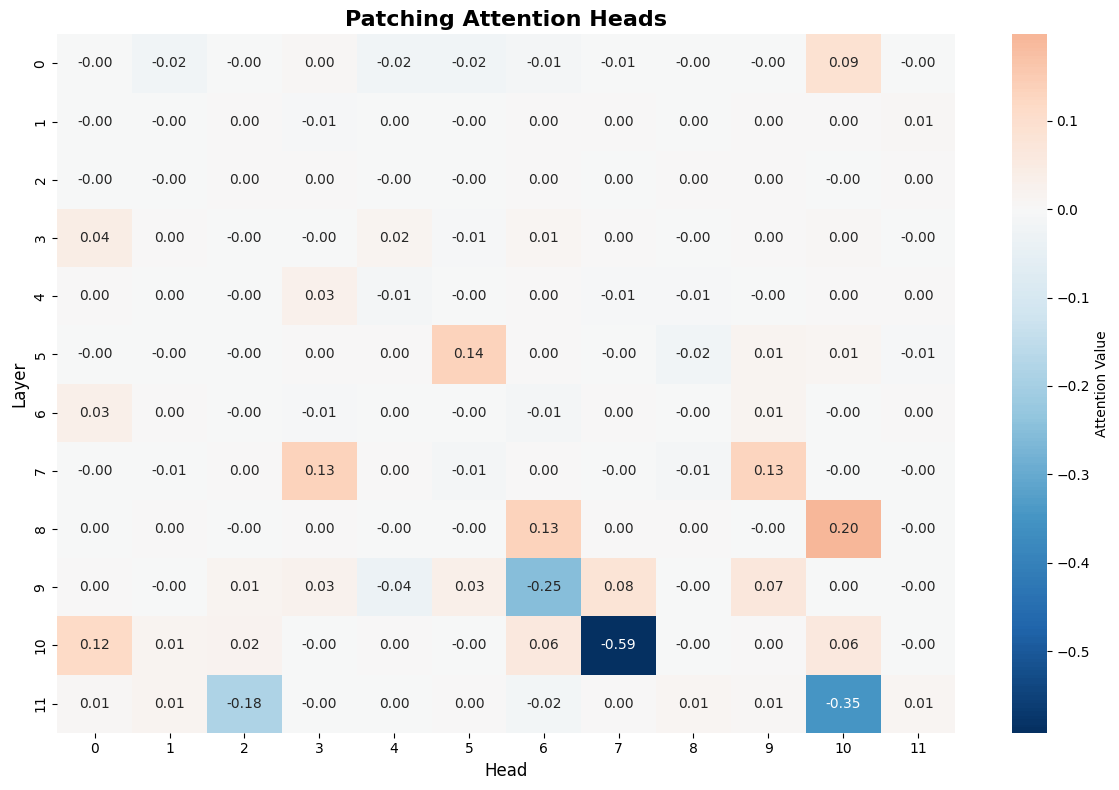

<Axes: title={'center': 'Patching Attention Heads'}, xlabel='Head', ylabel='Layer'>

In [11]:
def plot_attention_heatmap(results_path="results.pt", save_path="HeatMap.png", figsize=(12, 8), title="Patching Attention Heads"):
    # 加载tensor数据
    start_time = time.time()
    try:
        data = torch.load(results_path)
        # 如果数据在GPU上，转移到CPU
        if data.is_cuda:
            data = data.cpu()
        # 转换为numpy数组
        attention_matrix = data.numpy()
    except Exception as e:
        print(f"加载文件错误: {e}")
        return
    
    # 创建图形
    plt.figure(figsize=figsize)
    
    # 创建自定义的颜色映射：蓝色为负，红色为正
    # 使用RdBu_r颜色映射（Red-Blue reversed），这样蓝色表示负值，红色表示正值
    cmap = plt.cm.RdBu_r
    
    # 绘制热力图
    ax = sns.heatmap(attention_matrix, 
                     cmap=cmap,
                     center=0,  # 以0为中心
                     annot=True,  # 在单元格中显示数值
                     fmt=".2f",  # 数值格式
                     cbar_kws={'label': 'Attention Value'})
    
    # 设置标题和标签
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Head', fontsize=12)
    plt.ylabel('Layer', fontsize=12)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图像
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"热力图已保存至: {save_path}")
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"函数执行时间: {execution_time:.4f} 秒")
    plt.show()
    
    return ax


plot_attention_heatmap()